In [ ]:
from google.colab import drive
drive.mount("/content/mydrive")

Mounted at /content/mydrive


In [ ]:
# Import necessary library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras import callbacks


In [ ]:
# Chemin vers le répertoire contenant votre ensemble de données sur Google Drive
dataset_dir = '/content/mydrive/MyDrive/flowers'

# Créer les répertoires pour l'entraînement, la validation et le test
base_dir = '/content/gdrive/MyDrive/flower_dataset_splitted'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Copier les images dans les répertoires d'entraînement, de validation et de test
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    images = os.listdir(class_path)

    # Vérifiez si la taille de l'ensemble d'entraînement est suffisamment grande
    if len(images) < 2:
        continue

    train_images, test_val_images = train_test_split(images, test_size=0.2, random_state=1)

    # Vérifiez si la taille de l'ensemble de validation et de test est suffisamment grande
    if len(test_val_images) < 2:
        continue

    val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=1)

    # Créez des sous-répertoires par classe dans les ensembles d'entraînement, de validation et de test
    train_class_dir = os.path.join(train_dir, class_folder)
    os.makedirs(train_class_dir, exist_ok=True)

    val_class_dir = os.path.join(val_dir, class_folder)
    os.makedirs(val_class_dir, exist_ok=True)

    test_class_dir = os.path.join(test_dir, class_folder)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in train_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(train_class_dir, img)
        shutil.copy(src_path, dest_path)

    for img in val_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(val_class_dir, img)
        shutil.copy(src_path, dest_path)

    for img in test_images:
        src_path = os.path.join(class_path, img)
        dest_path = os.path.join(test_class_dir, img)
        shutil.copy(src_path, dest_path)

# Vérifiez le nombre d'images dans chaque sous-répertoire des ensembles d'entraînement, de validation et de test
print(f"Train Set: {sum(len(os.listdir(os.path.join(train_dir, class_folder))) for class_folder in os.listdir(train_dir))} images")
print(f"Validation Set: {sum(len(os.listdir(os.path.join(val_dir, class_folder))) for class_folder in os.listdir(val_dir))} images")
print(f"Test Set: {sum(len(os.listdir(os.path.join(test_dir, class_folder))) for class_folder in os.listdir(test_dir))} images")


Train Set: 3452 images
Validation Set: 430 images
Test Set: 435 images


In [ ]:
input_shape = (224, 224, 3)
num_classes = 5
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_directory(
    '/content/gdrive/MyDrive/flower_dataset_splitted/train',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = datagen.flow_from_directory(
    '/content/gdrive/MyDrive/flower_dataset_splitted/val',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = datagen.flow_from_directory(
    '/content/gdrive/MyDrive/flower_dataset_splitted/test',
    target_size = input_shape[:2],
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [ ]:
# Load the pre-trained ResNet50 model
pre_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in pre_model.layers:
    layer.trainable = False

x = Flatten()(pre_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Adding dropout layer
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Adding dropout layer
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Adding dropout layer
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=pre_model.inputs, outputs=x)



# Display a summary of the model's architecture
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# Train the model
earlystopping = callbacks.EarlyStopping(monitor ="loss", mode ="min", patience = 5, restore_best_weights = True)
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    batch_size = batch_size,
    callbacks =[earlystopping],
    verbose = 1
)

# save the model
model.save('model/Resnet50_model.h5')


Epoch 1/10
108/108 [==============================] - 75s 580ms/step - loss: 19.0106 - accuracy: 0.4878 - val_loss: 6.3962 - val_accuracy: 0.7791
Epoch 2/10
108/108 [==============================] - 58s 541ms/step - loss: 8.1001 - accuracy: 0.6567 - val_loss: 5.9235 - val_accuracy: 0.7930
Epoch 3/10
108/108 [==============================] - 58s 536ms/step - loss: 6.5294 - accuracy: 0.6903 - val_loss: 5.4897 - val_accuracy: 0.8070
Epoch 4/10
108/108 [==============================] - 59s 543ms/step - loss: 5.6214 - accuracy: 0.7068 - val_loss: 4.9518 - val_accuracy: 0.8279
Epoch 5/10
108/108 [==============================] - 62s 570ms/step - loss: 4.9592 - accuracy: 0.7517 - val_loss: 4.5717 - val_accuracy: 0.7977
Epoch 6/10
108/108 [==============================] - 63s 589ms/step - loss: 4.4685 - accuracy: 0.7738 - val_loss: 4.1524 - val_accuracy: 0.8442
Epoch 7/10
108/108 [==============================] - 59s 549ms/step - loss: 4.1999 - accuracy: 0.7726 - val_loss: 3.8932 - val_a

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('/content/model/Resnet50_model.h5')  # Example path

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

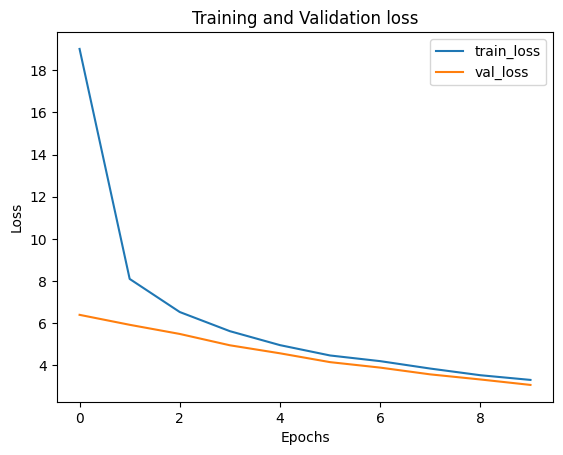

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

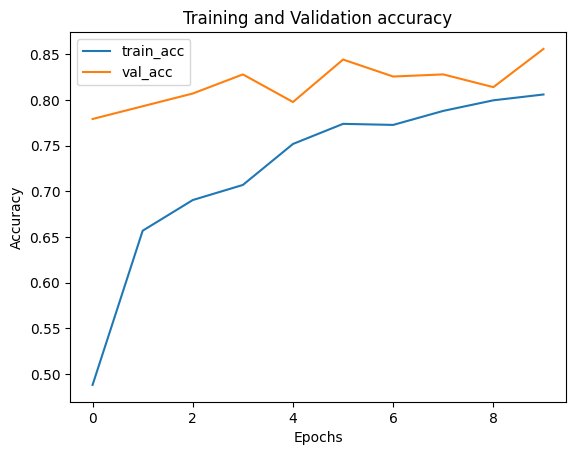

In [ ]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluation
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model = load_model('model/Resnet50_model.h5')

# Get the true labels for the test set
y_true = test_generator.classes

# Get the class indices
class_indices = test_generator.class_indices

# Convert the class indices to class names
class_names = list(class_indices.keys())

# Use the model to predict the labels for the test set
predictions = model.predict(test_generator)
# Convert predictions into class labels by selecting the index of the maximum probability for each sample.
y_pred = np.argmax(predictions, axis=1)

# y_true and y_pred are true and predicted labels
print(classification_report(y_true, y_pred, target_names=class_names))

14/14 [==============================] - 10s 635ms/step
              precision    recall  f1-score   support

       daisy       0.88      0.88      0.88        77
   dandelion       0.86      0.91      0.88       106
        rose       0.70      0.95      0.81        79
   sunflower       0.91      0.85      0.88        74
       tulip       0.94      0.68      0.79        99

    accuracy                           0.85       435
   macro avg       0.86      0.85      0.85       435
weighted avg       0.86      0.85      0.85       435



In [ ]:

# Evaluate the model on test data
loss, accuracy = model.evaluate(test_generator)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 16s 811ms/step - loss: 3.0573 - accuracy: 0.8690
Test Loss: 3.0572726726531982
Test Accuracy: 0.8689655065536499


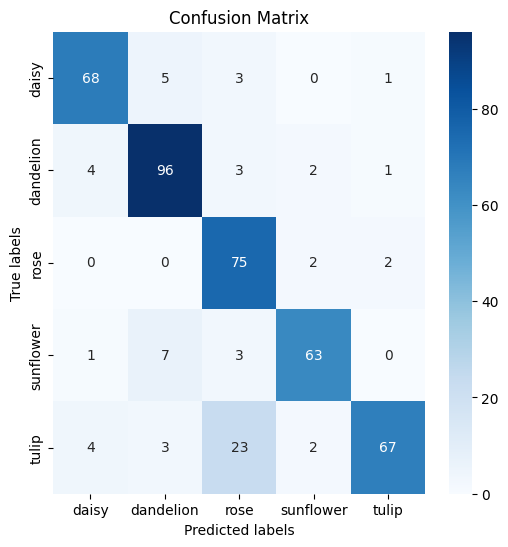

In [ ]:
import seaborn as sns
# Compute confusion matrix
confusion_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

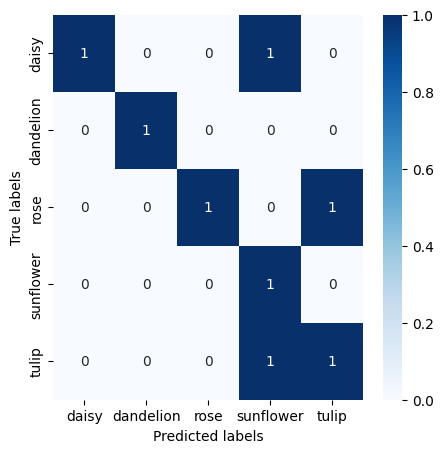

In [ ]:
import numpy as np

# Assuming confusion_matrix is defined somewhere in your code

# Define the threshold
threshold = 5  # Example threshold, adjust as needed

# Convert confusion matrix to binary matrix based on threshold
binary_confusion_matrix = np.where(confusion_matrix > threshold, 1, 0)

# Plot the binary confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(binary_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_true and y_scores are defined somewhere in your code
# y_true: les vraies étiquettes de classe
# y_scores: les scores de probabilité prédits pour chaque classe

# Calculer le taux de faux positifs (FPR) et le taux de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculer l'aire sous la courbe ROC (ROC-AUC)
roc_auc = roc_auc_score(y_true, y_scores)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_scores' is not defined